# Fitting data with `astropy.modeling`

**Authors:** Lia Corrales, Charee Peters, Anna Williams

**Learning Goals**
- Downloading data with `astroquery`
- Modeling data with `astropy.modeling`
- Plot with `matplotlib.pyplot.errobar` and play with parameters
- Write a function with a formatted doc string
- Define fit statistic
- Use `scipy.optimize`
- Combine `astropy.models` (e.g. a line plus a gaussian)

**Keywords:** 
Models, plots, errorbars, fitting, data retrieval, documentation, doc string, astroquery, matplotlib, scipy, astropy, statistics, Vizier

In this tutorial we will pull published cepheid variable data from Vizier using astroquery.  We use the astropy.modeling package to fit a line to the data set.  Along the way, we explore ways to visualize the data and fitting results using matplotlib.pyplot.errorbar.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.modeling import models, fitting

from astroquery.vizier import Vizier

# Automatically displays plots in notebook
%matplotlib inline  

## Load some data with `astroquery`

We are interested in using cepheid variable data from [Bhardwaj et al. 2017](https://www.aanda.org/articles/aa/pdf/2017/09/aa30841-17.pdf)...
We can pull the data from [Vizier](http://astroquery.readthedocs.io/en/latest/vizier/vizier.html#) using [astroquery](http://astroquery.readthedocs.io/en/latest/index.html)...


In [2]:
# Search for the data
catalog_list = Vizier.find_catalogs('bhardwaj cepheid')

# Look at which catalogs by Bhwardwaj are available on Vizier.
# We can also use the description keyword to get information 
# about the publication associated with each catalog.
print({k:v.description for k,v in catalog_list.items()})

{'J/A+A/605/A100': 'VVV survey Galactic Bulge Pop. II Cepheids (Bhardwaj+, 2017)', 'J/MNRAS/447/3342': 'Galactic and LMC Cepheids Fourier parameters (Bhardwaj+, 2015)'}


In [3]:
# We want the most recent catalog from J/A+A/605/A100
catalog_test = Vizier.get_catalogs('J/A+A/605/A100') 

# Take a look at what we grabbed
print(catalog_test)

TableList with 1 tables:
	'0:J/A+A/605/A100/table1' with 16 column(s) and 50 row(s) 


If we take a look at [Bhardwaj et al. 2017](https://www.aanda.org/articles/aa/pdf/2017/09/aa30841-17.pdf), we see there are over 200 data points, but our catalog only contains 50 rows.  That's because the retrieval default only selects the first 50 rows of the catalog.  We need to reset that limit, and rerun `Vizier.get_catalogs()`.

In [4]:
# it only has 50 rows, but the actual data set contains 200+ cepheids
# we can change this by setting ROW_LIMIT
Vizier.ROW_LIMIT = -1

catalog = Vizier.get_catalogs('J/A+A/605/A100')
print(catalog)

TableList with 1 tables:
	'0:J/A+A/605/A100/table1' with 16 column(s) and 264 row(s) 


This print tells us that there is 1 table (index = 0) with 16 columns and 24 rows.

In [5]:
# let's see the available columns/keys in the dict
print(catalog[0].keys())

['VVV-ID', 'OGLE-ID', 'Period', 'Class', '__Vmag_', '__Imag_', '__Jmag_', '__Hmag_', '__Ksmag_', 'e__Jmag_', 'e__Hmag_', 'e__Ksmag_', 'E_J-Ks_', 'Simbad', '_RA', '_DE']


In [6]:
def clean_data(data_list):
    ## Returns a filter for cases where all the data is finite
    filters = np.array([np.isfinite(d) for d in data_list], dtype=bool)
    result  = np.ones_like(data_list[0])
    for f in filters:
        result = np.logical_and(result, f)
    return result

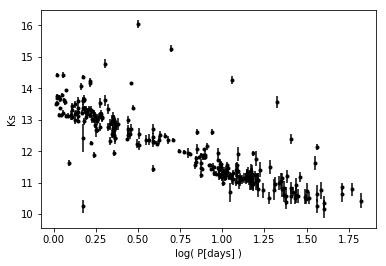

In [7]:
# We want the Period and K-band magnitudes ('__Ksmag_')
period = np.array(catalog[0]['Period']) # recast table.column to np.array
k_mag = np.array(catalog[0]['__Ksmag_'])
k_mag_err = np.array(catalog[0]['e__Ksmag_'])

# after creating np.arrays from the table.column we ended up replacing
# the column titles with nans so we need to filter them out
myfilt = clean_data([period, k_mag, k_mag_err])
period = period[myfilt]
k_mag = k_mag[myfilt]
k_mag_err = k_mag_err[myfilt]

log10_period = np.log10(period) # the Period-Luminosity relation is actually 
                                # a log-log relation

# visualize the data
plt.errorbar(log10_period,k_mag,yerr=k_mag_err,fmt='k.')
plt.xlabel('log( P[days] )')
plt.ylabel(r'Ks')

Remember the y-axis is in magnitudes, so the usual way to plot the data would be to have magnitudes ***decrease*** instead of increase.  Here is how we flip the y-axis.

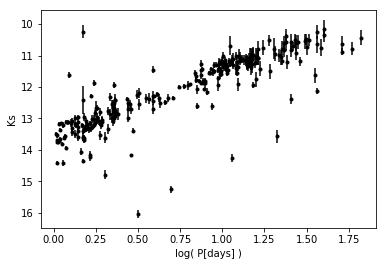

In [8]:
plt.errorbar(log10_period,k_mag,yerr=k_mag_err,fmt='k.')
plt.xlabel('log( P[days] )')
plt.ylabel(r'Ks')
plt.gca().invert_yaxis() # command to flip the y-axis

Try using different values for `fmt=` to change the marker.

Try changing the [marker](http://matplotlib.org/devdocs/api/_as_gen/matplotlib.axes.Axes.errorbar.html) to a different symbol.

## Write your own line function

Let's write a function that returns a line with slope $m$ and y-intercept $b$, so that $y = mx + b$

In [9]:
def my_line(x, m, b):
    """
    x : input data for the line model
    m : slope of the line model
    b : y-intercept of the line model
    ---
    Calculates y = mx + b and returns only the y-values.
    """
    return m * x + b

Now let's set up a grid of $x$ values and evaluate our line function with our favorite $m$ and $b$.  I will use the minimum and maximum values of the data points to define the endpoints of the $x$ grid.

In [10]:
nx    = 1000  # Number of x values to use in our grid
xgrid = np.linspace(np.min(log10_period), np.max(log10_period), nx)

m0, b0 = -1.0, 14.0 # don't forget, we flipped the y-axis, so the slope should be negative!
model0 = my_line(xgrid, m0, b0)

Now let's plot it with the scatter plot to see how our model compares.

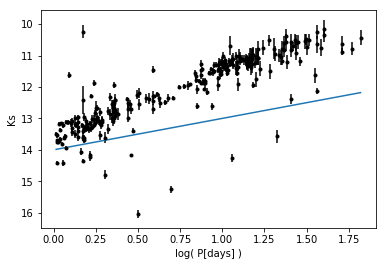

In [11]:
plt.errorbar(log10_period,k_mag,yerr=k_mag_err,fmt='k.')
plt.xlabel('log( P[days] )')
plt.ylabel(r'Ks')
plt.gca().invert_yaxis()

plt.plot(xgrid, model0)

How did it do?  Pick some values of `m0` and `b0` that look good to you.

## Using `astropy.modeling` package to set up a line model

The [astropy.modeling](http://docs.astropy.org/en/stable/modeling/) package contains many analytical functions that are generally useful.  You can find a list of them in [this table](http://docs.astropy.org/en/stable/modeling/#module-astropy.modeling.functional_models)


Let's use one to replace our custom line model function.  We will use the `Linear1D` model object, which we will need to initiate with our favorite $m$ and $b$ values.

In [12]:
linear_model = models.Linear1D(m0, b0)

Now we can evaluate our model by supplying the `linear_model` object with the $x$ values we desire.

Let's plot the linear model with our `xgrid` values, like before.

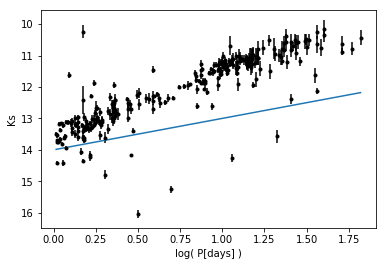

In [13]:
plt.errorbar(log10_period,k_mag,yerr=k_mag_err,fmt='k.')
plt.xlabel('log( P[days] )')
plt.ylabel(r'Ks')
plt.gca().invert_yaxis()

plt.plot(xgrid, linear_model(xgrid))

## Using the `astropy.modeling` to fit the data

We just fit the data by choosing the intercept and slope of the line.  This is not the most robust way of doing this.  Instead, we can use tools available in [astropy.modeling](http://docs.astropy.org/en/stable/modeling/) to fit a line.  
We begin by initializing the model fitting by using our previous best guess for the line parameters and initializing the model fitter.  There are a variety of model fitters available in this package.  Here, we use [astropy.fitting.LinearLSQFitter](http://docs.astropy.org/en/stable/api/astropy.modeling.fitting.LinearLSQFitter.html#astropy.modeling.fitting.LinearLSQFitter) to do a linear least-squares fit to the data.  

In [14]:
init_guess = models.Linear1D(slope=m0, intercept=b0) # initial parameter guess

fit_line = fitting.LinearLSQFitter()  # initializes the fitter
line_param = fit_line(model=init_guess, x=log10_period, y=k_mag)

We can print the results of the linear least squares fit.

In [15]:
print(line_param)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        slope       intercept  
    ------------- -------------
    -1.9318212333 13.5544400551


Now that we have a new line, let's plot it with the data.

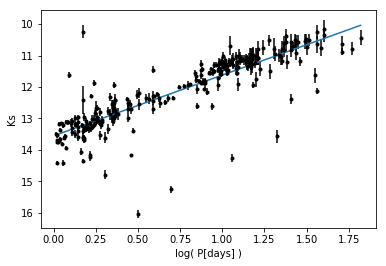

In [16]:
plt.errorbar(log10_period,k_mag,yerr=k_mag_err,fmt='k.')
plt.xlabel('log( P[days] )')
plt.ylabel(r'Ks')
plt.gca().invert_yaxis()

model_fit = line_param(xgrid) # create np.array with new fit parameters

plt.plot(xgrid, model_fit)

We can also do this fitting with [astropy.fitting.LinearLSQFitter](http://docs.astropy.org/en/stable/api/astropy.modeling.fitting.LevMarLSQFitter.html#astropy.modeling.fitting.LevMarLSQFitter), which also works to fit any generic function.  [astropy.modeling](http://docs.astropy.org/en/stable/modeling/) provides a variety of models and fitting routines that are useful when the data can not be fit with a simple line.  For example, there are specifc models if it's known that data follows a specific distribution, e.g. the data has a Gaussian distribution there is [Gaussian model fitting](https://github.com/spacetelescope/aas229_workshop/blob/master/Lecture_Notebooks/modeling/aas229_Modeling.ipynb).

## Setting up your own fitting statistic

## How to generate random data

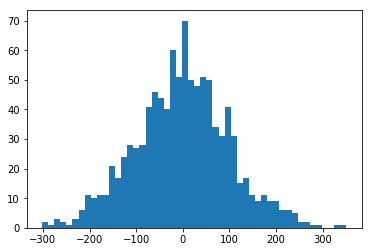

In [17]:
# To begin, we need to define our Guassian parameters (e.g. the mean and standard deviation)
mean  = 0 # This is our mean
sigma = 100 # This is our standard deviation

# To generate our data, we can use the numpy random generator normal distribution function.
# Let's create 1000 points for now. 
gaussian_data = np.random.normal(mean, sigma, 1000)

# bin data and plot a histogram; overplot your guassian fit
# To visualize our data, let's bin it into 50 bins
bins  = 50
_ = plt.hist(gaussian_data, bins)

plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - mean)**2 / (2 * sigma**2) ),
          linewidth=2, color='r')
#plt.show()

<Container object of 3 artists>

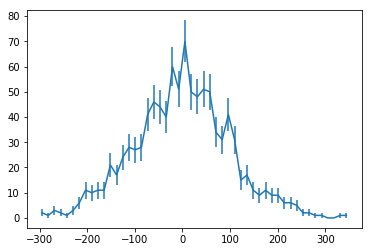

In [18]:
hist_values, bin_edges = np.histogram(gaussian_data, bins)
hist_error = np.sqrt(hist_values)
bin_center = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.errorbar(bin_center, hist_values, yerr=hist_error)

Try playing with the number of data points and see how that changes our error bars. 

# Extra Bonus Objectives

Written by Lia

## How to simulate a stellar spectrum with noise

In this example, we will simulate a black body spectrum with noise.

First, we will load the [black body module](http://docs.astropy.org/en/stable/modeling/#module-astropy.modeling.blackbody) from `Astropy.modeling`

In [19]:
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu

Now let's set up our model grid for $\lambda$ (the wavelength of the light).  Note that $c = \lambda \nu$, where $\nu$ is the frequency and $c$ is the speed of light.

We will call the variable `wavelength` because `lambda` is a built-in Python construct that we won't be able to use as a variable name.

In [20]:
wmin, wmax = 1000., 10000.  # Angstroms
nbins      = 1000  # Number of bins to use
wavelength = np.linspace(wmin, wmax, nbins) * u.AA  # Angstroms

We'll be using the equation $F_{\lambda} = ???$ with a reasonable temperature for a stellar surface like our sun.

In [21]:
temperature = 6000. * u.K  # Kelvin
intensity_lambda = blackbody_lambda(wavelength, temperature)

Let's see what units were returned by the blackbody function.

In [22]:
print(intensity_lambda.unit)

erg / (Angstrom cm2 s sr)


For a perfectly spherical stellar point source, we multiply the intensity by a factor of $\pi$ (or something) steridians (the sr unit).  

If we want to estimate the number of photon counts in our image, then we also need to multiply the flux by the effective area of our telescope, an exposure time, the energy of the photons as each wavelength, and our bin width.

In [23]:
solid_angle    = np.pi * u.sr
effective_area = 1.e4 * u.cm**2
exposure_time  = 1.0 * 60. * u.s  # 1 minute in units of seconds
photon_energy  = wavelength.to(u.erg, equivalencies=u.spectral())  # See astropy.units tutorial

estimated_counts = intensity_lambda * solid_angle * effective_area * exposure_time / photon_energy

What are the units on estimated_counts?  Why?

Let's get an estimated number of photon counts in each bin

In [24]:
bin_width      = wavelength[1] - wavelength[0]  # Only works if the bins are linearly spaced
counts_per_bin = estimated_counts * bin_width

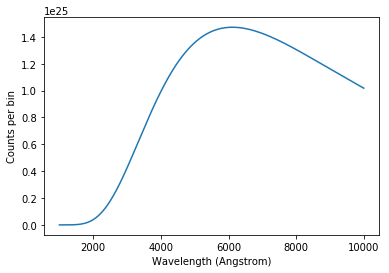

In [25]:
plt.plot(wavelength, counts_per_bin)
plt.xlabel("Wavelength (%s)" % wavelength.unit)
plt.ylabel("Counts per bin")

** Finish this another time **

In [26]:
## Note from Lia -- I just made some random data that goes in a line for now
xmin, xmax, my_m, my_b, ysig = 0, 100., 3.0, 2.0, 50.0
npoints = 100,
aq_x    = np.random.uniform(xmin, xmax, npoints)
aq_y    = np.random.normal(my_m * aq_x + my_b, ysig)
aq_yerr = np.abs(np.random.normal(0.0, ysig/2.0, npoints))  # Use randomly generated error bars for now

Let's make a scatter plot of the data.

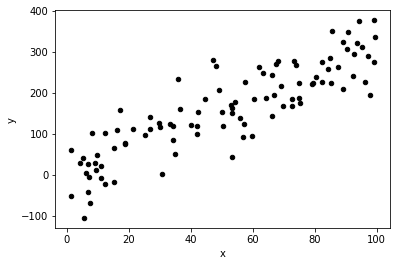

In [27]:
plt.scatter(aq_x, aq_y, s=20, color='k')
plt.xlabel("x")
plt.ylabel("y")

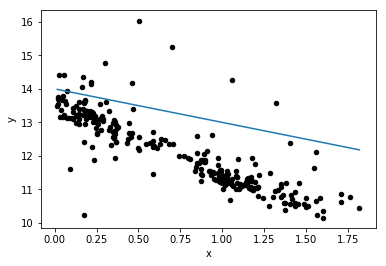

In [28]:
plt.scatter(log10_period, k_mag, s=20, color='k')
plt.xlabel("x")
plt.ylabel("y")

plt.plot(xgrid, model0)